# [#29.Lab] Stock Prediction with LSTM - 딥러닝 홀로서기

<시작 전에 보면 좋은 자료들>  
* LSTM을 시각적으로 쉽게 이해하고 싶다면 -> [Understanding LSTM Networks - Colah's Blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)    
* pytorch에서 나만의 데이터셋을 만들려면? -> [Data Loading Tutorial - Pytorch Official Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)  
* LSTM을 pytorch에서 정확하게 쓰려면? -> [LSTM for time series in pytorch - Jessica's Blog](http://www.jessicayung.com/lstms-for-time-series-in-pytorch/)   


* [실습 영상](https://www.youtube.com/watch?v=javWSq-5xzw&list=PLSAJwo7mw8jn8iaXwT4MqLbZnS-LJwnBd&index=28)
* [실습자료 링크](https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec8/Lab10_Stock_Price_Prediction_with_LSTM.ipynb)

In [3]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.4.0
Populating the interactive namespace from numpy and matplotlib


## Pandas Datareader Test

In [4]:
# We will look at stock prices over the past year, starting at January 1, 2016
# padas datareader 로 구글 서버에 접속해서 API 를 사용해 주가를 받아옴

start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('028050.KS', 'yahoo', start, end) #삼성엔지니어링 주가 , 야후서버

In [9]:
print(type(google))
google
#Adj Close : 장외가격?
#x : 6차원 (6,일수)

<class 'pandas.core.frame.DataFrame'>


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-12-01,2500.0,2420.0,2495.0,2500.0,222800.0,1927.813110
2000-12-04,2560.0,2450.0,2500.0,2470.0,196100.0,1904.679199
2000-12-05,2500.0,2455.0,2455.0,2485.0,158800.0,1916.245728
2000-12-06,2580.0,2490.0,2530.0,2490.0,287600.0,1920.101562
2000-12-07,2490.0,2455.0,2470.0,2465.0,147900.0,1900.823608
...,...,...,...,...,...,...
2021-07-27,24250.0,23000.0,23050.0,23850.0,3673855.0,23850.000000
2021-07-28,24300.0,23550.0,23850.0,24250.0,2636082.0,24250.000000
2021-07-29,24550.0,23500.0,24500.0,23950.0,3625252.0,23950.000000


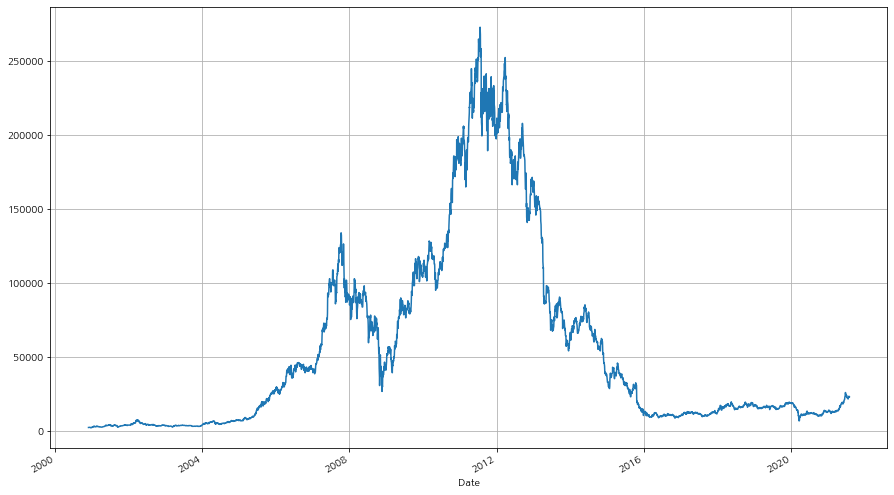

In [7]:
google.Low.plot(grid=True) #Low 컬럼을 가져옴, #plt그림

In [10]:
google.tail()
print(google.isna().sum())
#결측값 없음

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


## Data Preparation

### Dataset vs DataLoader
* Dataset : i번째 레코드 값을 주는 역할
* DataLoader : Dataset에서 batch 를 만들어줌

In [24]:
#Dataset, DataLoader 예제
#가상의 table data가 있다고 할때
class dummySet(Dataset) :
    
    def __init__(self, num_data) :
        self.x = np.array(list(range(num_data*2))).reshape(-1,2) #2차원 array
        self.y = np.array(list(range(num_data)))
        
    def __len__(self) :
        return len(self.x)
    
    def __getitem__(self, idx) : 
        return self.x[idx, :], self.y[idx]

In [33]:
dataset = dummySet(100)
dataloader = DataLoader(dataset, 3, shuffle=True, drop_last = True) #batchsize =3

In [34]:
#LSTM 은 batch size에 dependent하게 모델을 만들기때문에 drop_last=True 해줘야함
for x, y in dataloader :
    print(x.shape, y.shape)
    print(x, y)

torch.Size([3, 2]) torch.Size([3])
tensor([[114, 115],
        [118, 119],
        [136, 137]], dtype=torch.int32) tensor([57, 59, 68], dtype=torch.int32)
torch.Size([3, 2]) torch.Size([3])
tensor([[ 50,  51],
        [ 26,  27],
        [182, 183]], dtype=torch.int32) tensor([25, 13, 91], dtype=torch.int32)
torch.Size([3, 2]) torch.Size([3])
tensor([[  8,   9],
        [122, 123],
        [ 96,  97]], dtype=torch.int32) tensor([ 4, 61, 48], dtype=torch.int32)
torch.Size([3, 2]) torch.Size([3])
tensor([[134, 135],
        [154, 155],
        [160, 161]], dtype=torch.int32) tensor([67, 77, 80], dtype=torch.int32)
torch.Size([3, 2]) torch.Size([3])
tensor([[76, 77],
        [94, 95],
        [60, 61]], dtype=torch.int32) tensor([38, 47, 30], dtype=torch.int32)
torch.Size([3, 2]) torch.Size([3])
tensor([[ 24,  25],
        [176, 177],
        [ 70,  71]], dtype=torch.int32) tensor([12, 88, 35], dtype=torch.int32)
torch.Size([3, 2]) torch.Size([3])
tensor([[ 62,  63],
        [ 68,  69],
 

------------------------------------

In [11]:
#동시에 t+1, t+2를 동시에 학습
#t+1만 학습하면, t랑 똑같이 학습함
class StockDataset(Dataset): #상속
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        #x_frames : n일의 데이터
        #y_frames : 이후 m일의 데이터
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        #data에 dataframe 저장
        self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        #1,2,3,4,5 일의 데이터가 있고, x_frames=2, y_frames=2 라면
        #1,2 - 3,4
        #2,3 - 4,5
        #2개의 데이터 쌍이 있다.
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames] #idx 기준으로 x, y 가져옴
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']] #순서 맞추기 위함
        #가격이 만원단위, 시간에 따라서 변동이 큼 -> normalization
        #최근꺼로 나눠도 됨
        #log(a) - log(b) = log(a/b)
        #log의 차이로 함 -> 나누기로하면, 주가가 0일때가 있을 수도 있으므로.
        #log0은 마이너스 무한대이므로 +1을 그냥 다 해줌
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values #df를 numpy array로 converting 해줌
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [43]:
dataset = StockDataset('028050.KS', 10, 5, (2000,1,1), (2005,1,1))
dataloader = DataLoader(dataset, 2)
for X, y in dataloader : 
    print(X.shape, y.shape)
    break

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
torch.Size([2, 10, 6]) torch.Size([2, 5, 6])


## Model Define

In [85]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        # lstm_out = Y로 보내려는 ht
        #print('x : ' ,x.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        #print(type(lstm_out), type(self.hidden)) #hidden : 0:hiddenstate, 1:cellstate
        #print('lstm_out : ', lstm_out.shape, 'hidden : ', self.hidden[0].shape,self.hidden[1].shape )
        
        #print('lstm_out[-1] : ' ,lstm_out[-1].shape)
        #print('lstm_out[-1].view(self.batch_size, -1) : ' ,lstm_out[-1].view(self.batch_size, -1).shape)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        #print('y_pred : ' ,y_pred.shape)
        return y_pred

In [86]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

## Train, Validate, Test

In [94]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):
        #print('raw', X.shape, y.shape)
        
        #한 step별로 forward 진행-> 차원 뒤집음
        # 10 : batch size
        # n : sequence length (n일치)
        # m : 예측하는 m 일치
        # X : [10, n, 6] -> [n, 10, 6]sequence length, batch_size, x_dimention
        # Y : [10, m, 1] [10, m],  종가 가격만 예측. 
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        
        #print('processed', X.shape, y_true.shape)
        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [95]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [96]:

def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [97]:

def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

## Manage Experiment

In [98]:

import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [99]:

def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [100]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 10
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]

trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
Namespace(batch_size=128, device='cpu', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=10, y_frames=5)
Epoch 0, Acc(train/val): 4.39/3.26, Loss(train/val) 0.00842/0.00496. Took 14.26 sec
Epoch 1, Acc(train/val): 2.91/2.52, Loss(train/val) 0.00388/0.00381. Took 14.34 sec
Namespace(batch_size=128, device='cpu', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=2, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=10, y_frames=5)
Epoch 0, Acc(train/val): 8.96/9.66, Loss(train/val) 0.01413/0.00649. Took 14.55 sec
Epoch 1, Ac

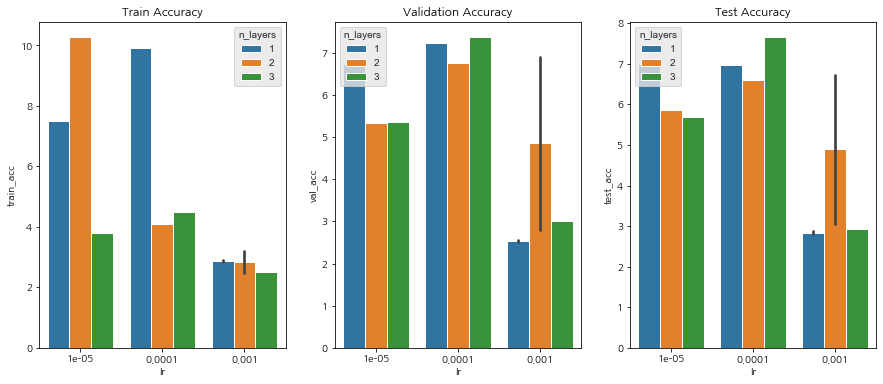

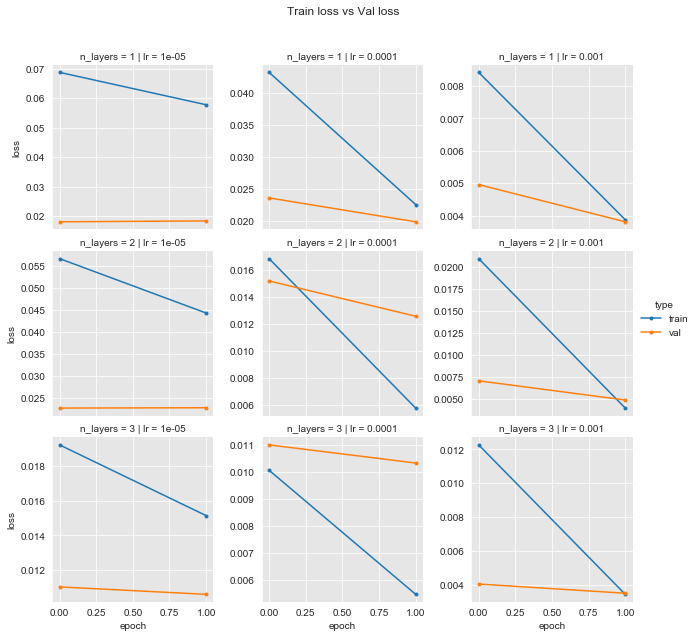

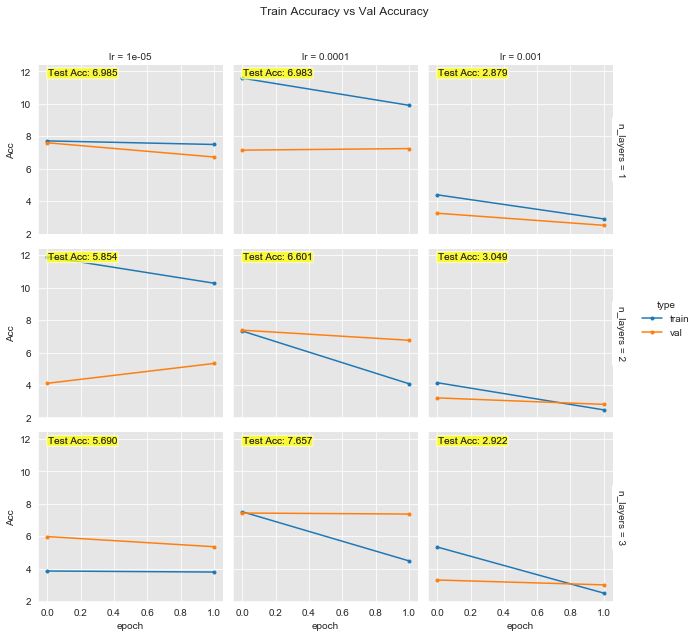

In [101]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)